In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd /gdrive/My Drive/BA/data_per_stores
!ls

/gdrive/My Drive/BA/data_per_stores
data_CA_1.csv  data_CA_3.csv  data_TX_1.csv  data_TX_3.csv  data_WI_2.csv
data_CA_2.csv  data_CA_4.csv  data_TX_2.csv  data_WI_1.csv  data_WI_3.csv


# **1. Data cleaning** 

In [4]:
def clean(df):
    df.drop(columns = ['Unnamed: 0','id','store_id','date','weekday','sell_price','event_name_1','event_name_2'],inplace=True)
    # get the day number
    df['day'] = df.d.apply(lambda x: x[2:])
    # get the week number
    df['week'] = df.wm_yr_wk.apply(lambda x: x%100)
    # let 'snap_dummy' denote if snap is allowed in the state. 
    df['snap_CA'] = df.snap.apply(lambda x: x[0])
    df['snap_TX'] = df.snap.apply(lambda x: x[2])
    df['snap_WI'] = df.snap.apply(lambda x: x[4])
    
    df.drop(columns = ['d','wm_yr_wk','snap'],inplace=True)
    
    df.day = df.day.astype(int)
    df.snap_CA = df.snap_CA.astype(int)
    df.snap_TX = df.snap_TX.astype(int)
    df.snap_WI = df.snap_WI.astype(int)
    
    df_y = df.groupby('day').sum().demand.reset_index(drop = True)
    df_x = df.drop(columns = ['demand']).drop_duplicates().reset_index(drop = True)
    # onehot encoding for event_type_1 and event_type_2
    df_x = pd.get_dummies(df_x,columns = ['event_type_1','event_type_2'])
    
    # train-valid split, use last 28 days as validation
    df_xtrain = df_x.iloc[:-28,:]
    df_xvalid = df_x.iloc[-28:,:]
    df_ytrain = df_y.iloc[:-28]
    df_yvalid = df_y.iloc[-28:]
    
    return df_xtrain,df_ytrain,df_xvalid,df_yvalid
    

In [5]:
def rmsse(y_train,y_test,y_pred):
    y_train1 = y_train.shift()
    n = len(y_train)
    h = len(y_test)
    dividor = sum((y_train[1:]-y_train1[1:])**2)/(n-1)
    divident = sum((y_test-y_pred)**2)/h
    
    return divident/dividor

# **2. ML Models : Random Forest and Boosted Trees**

In [6]:
# random forest
def rf_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid):
    model = rfr().fit(df_xtrain,df_ytrain)
    df_ypred = model.predict(df_xvalid).round().astype(int)
    
    # calculate rmsse
    print('RMSSE with Random Forest:',rmsse(df_ytrain,df_yvalid,df_ypred))
    print('\n')
    
    # plot prediction
    print('Random Forest Forecasting')
    a = df_yvalid.reset_index(drop=True)
    plt.figure(figsize = (10,6))
    plt.xlabel('days')
    plt.plot(range(28),a, label = 'Real data')
    plt.plot(range(28),df_ypred, label = 'Predictions')
    plt.legend()
    plt.show()
    
    # plot feature importance
    variable_importance = []
    for i in range(len(df_xtrain.columns)):
        variable_importance.append((df_xtrain.columns[i],model.feature_importances_[i]))
    variable_importance.sort(key = operator.itemgetter(1), reverse=True)
    selected_variable = [x[0] for x in variable_importance]
    selected_importance = [x[1] for x in variable_importance]
    plt.figure(figsize=(30,6))
    plt.bar(selected_variable,selected_importance)
    plt.ylabel("Feature Importance with Random Forest")
    plt.show()
    
    return df_ypred

In [7]:
# gradient boost
def gb_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid):
    model = gbr().fit(df_xtrain,df_ytrain)
    df_ypred = model.predict(df_xvalid).round().astype(int)
    
    # calculate rmsse
    print('RMSSE with Gradient Boosting:',rmsse(df_ytrain,df_yvalid,df_ypred))
    print('\n')
    
    # plot prediction
    print('Gradient Boosting Forecasting')
    a = df_yvalid.reset_index(drop=True)

    plt.figure(figsize = (10,6))
    plt.xlabel('days')
    plt.plot(range(28),a, label = 'Real data')
    plt.plot(range(28),df_ypred, label = 'Predictions')
    plt.legend()
    plt.show()
    
    # plot feature importance
    variable_importance = []
    for i in range(len(df_xtrain.columns)):
        variable_importance.append((df_xtrain.columns[i],model.feature_importances_[i]))
    variable_importance.sort(key = operator.itemgetter(1), reverse=True)
    selected_variable = [x[0] for x in variable_importance]
    selected_importance = [x[1] for x in variable_importance]
    plt.figure(figsize=(30,6))
    plt.bar(selected_variable,selected_importance)
    plt.ylabel("Feature Importance with Gradient Boosting")
    plt.show()
    
    return df_ypred

# **3. Apply it to our data**

# 3.1 Work on Wisconsin Stores

In [8]:
df_WI_1 = pd.read_csv('data_WI_1.csv')
df_WI_2 = pd.read_csv('data_WI_2.csv')
df_WI_3 = pd.read_csv('data_WI_3.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RMSSE with Random Forest: 0.3526532763223056


Random Forest Forecasting


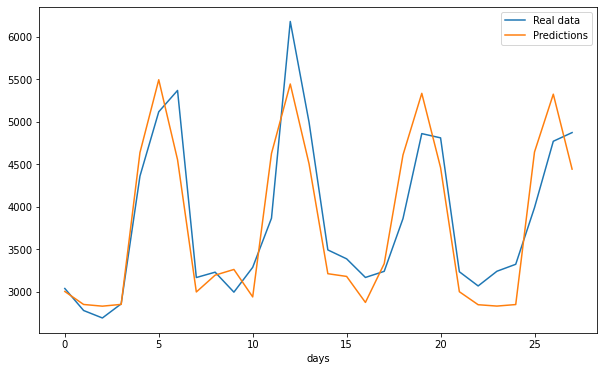

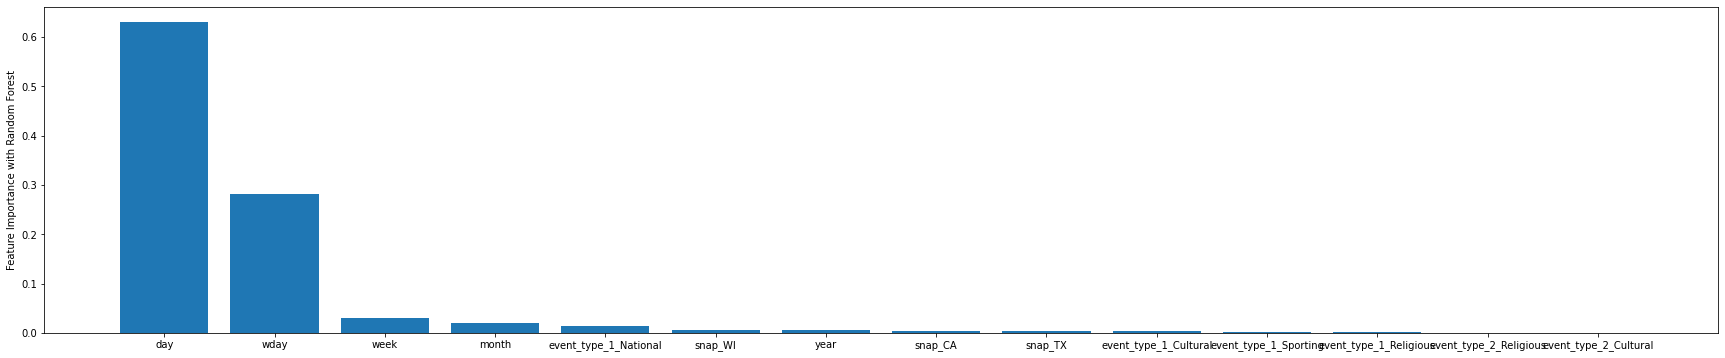

RMSSE with Gradient Boosting: 0.8888937014962142


Gradient Boosting Forecasting


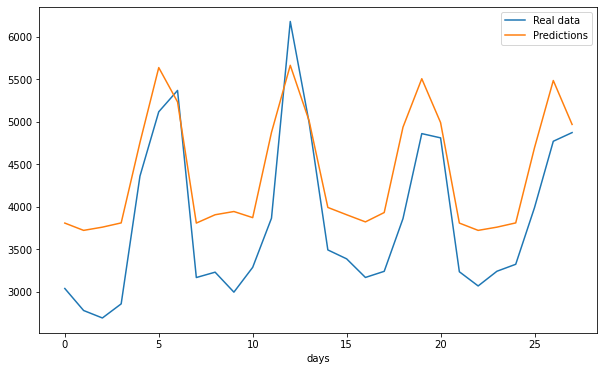

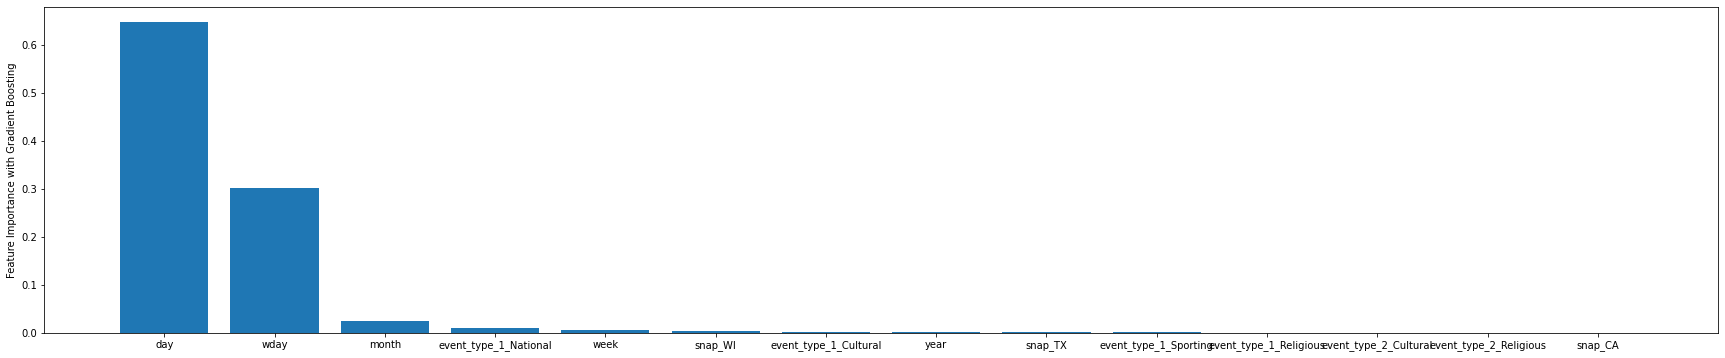

RMSSE with Random Forest: 0.6652863230273406


Random Forest Forecasting


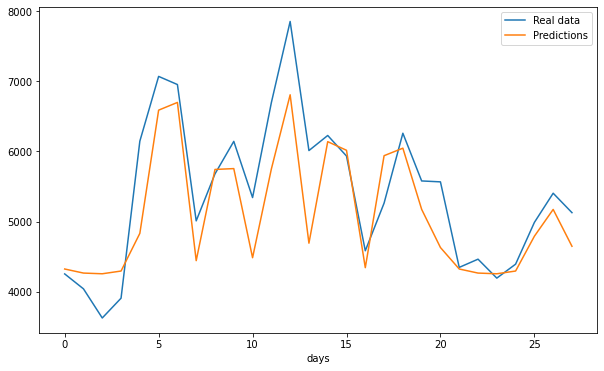

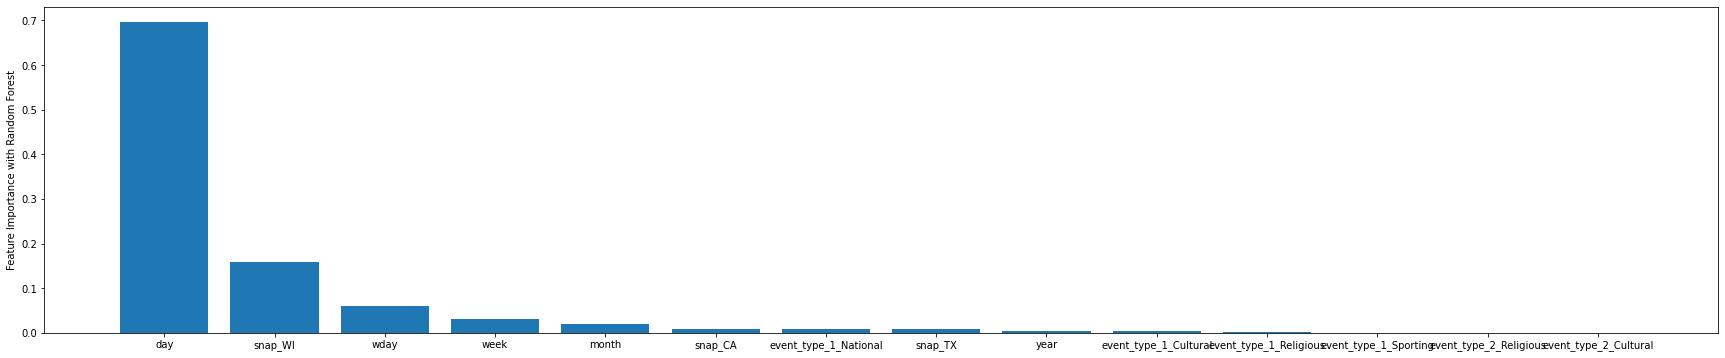

RMSSE with Gradient Boosting: 0.5573134848718757


Gradient Boosting Forecasting


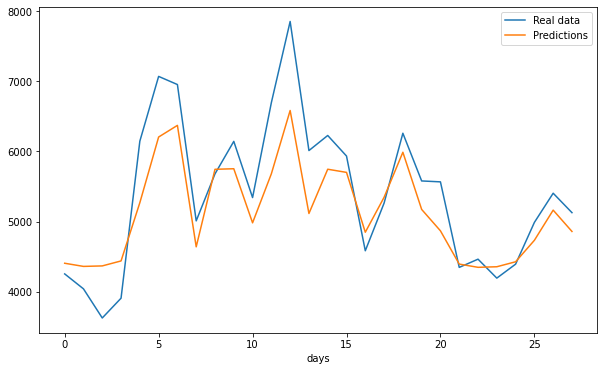

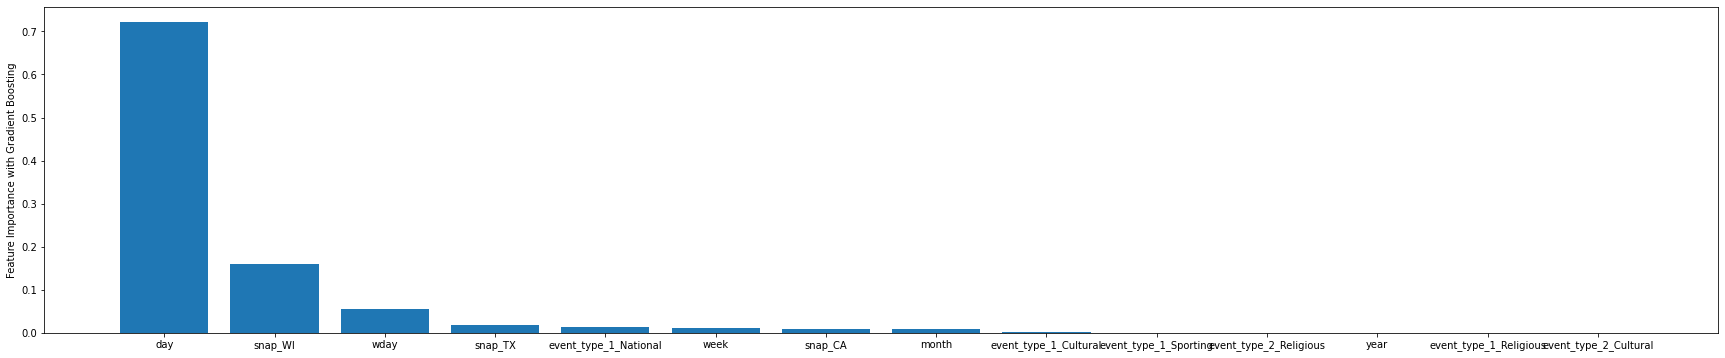

RMSSE with Random Forest: 0.20983611048447906


Random Forest Forecasting


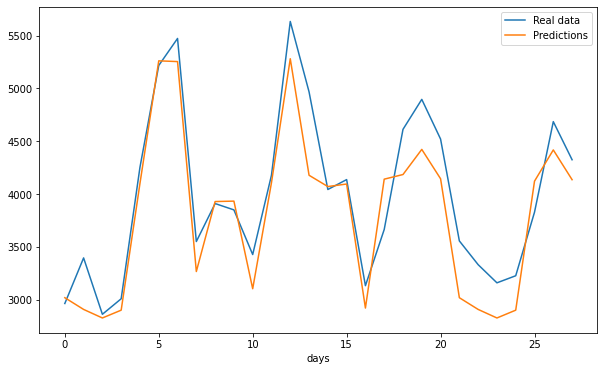

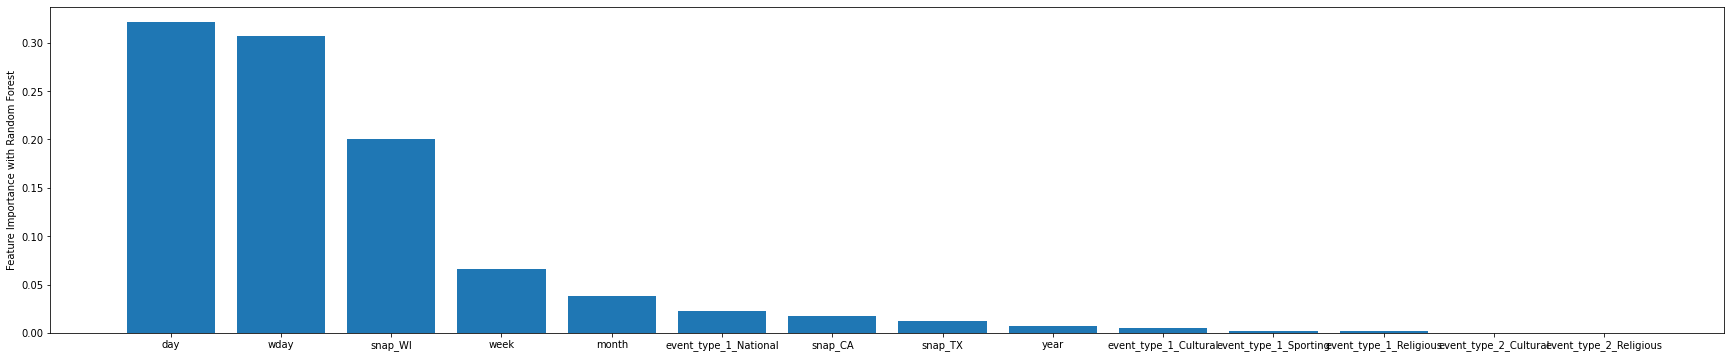

RMSSE with Gradient Boosting: 0.26712306030133787


Gradient Boosting Forecasting


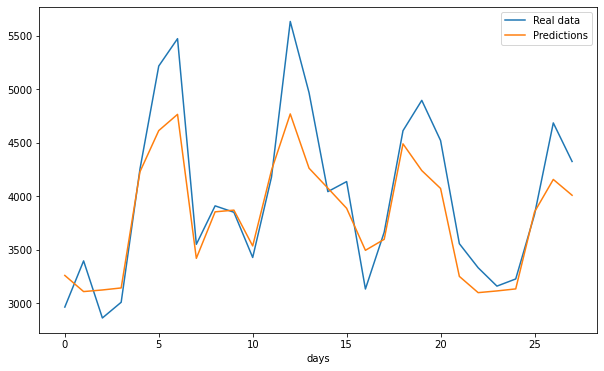

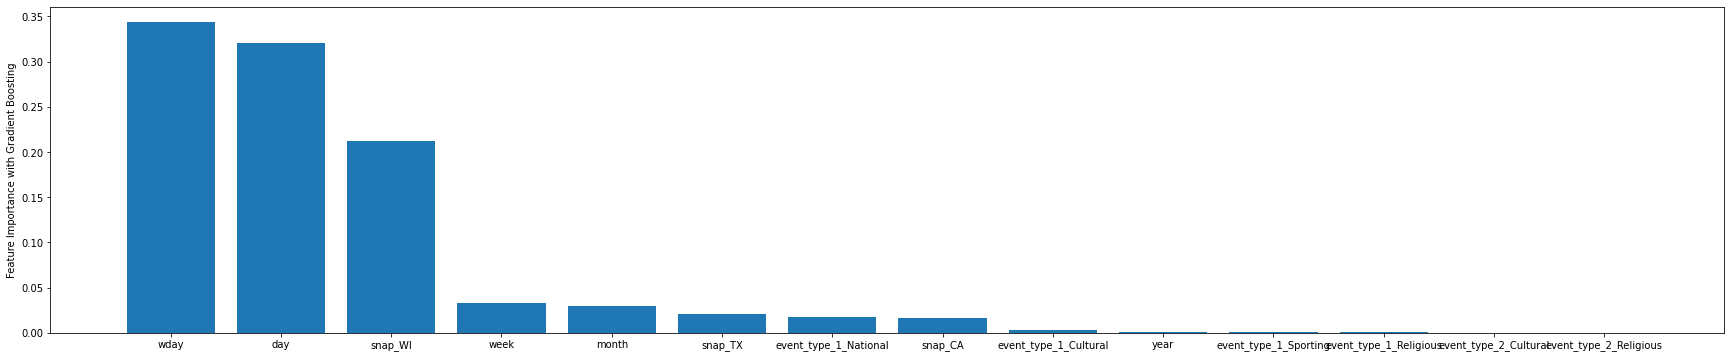

In [9]:
rf_pred_WI = []
gb_pred_WI = []
for df in [df_WI_1,df_WI_2,df_WI_3]:
    df_xtrain,df_ytrain,df_xvalid,df_yvalid = clean(df)
    rf_pred_WI.append(rf_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))
    gb_pred_WI.append(gb_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))

# 3.2 Work on Texas Stores

In [10]:
df_TX_1 = pd.read_csv('data_TX_1.csv')
df_TX_2 = pd.read_csv('data_TX_2.csv')
df_TX_3 = pd.read_csv('data_TX_3.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RMSSE with Random Forest: 0.1435670115363418


Random Forest Forecasting


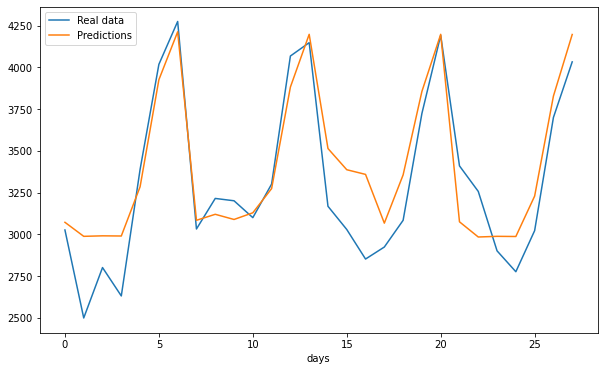

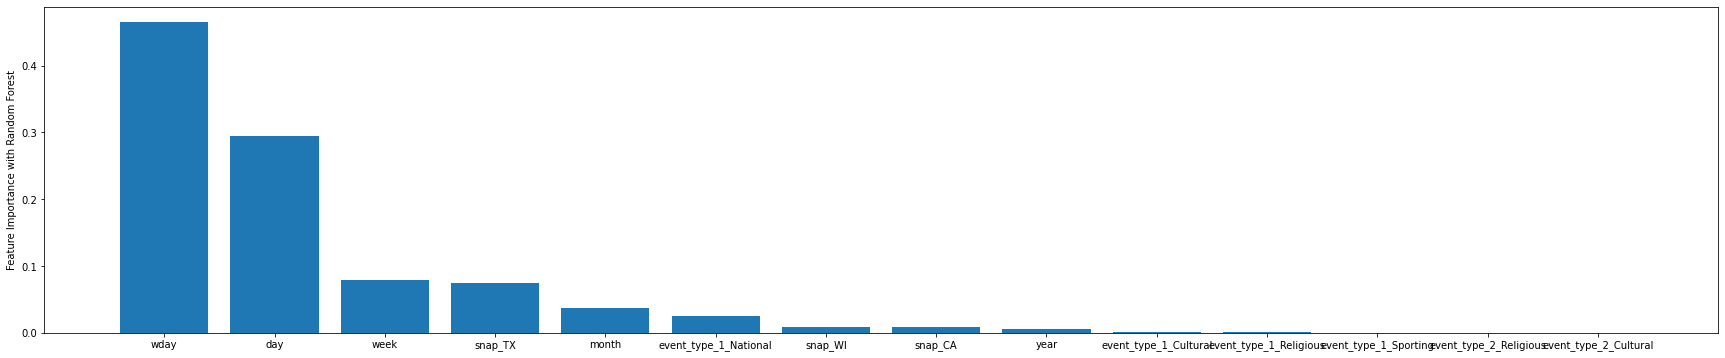

RMSSE with Gradient Boosting: 0.27237853912528265


Gradient Boosting Forecasting


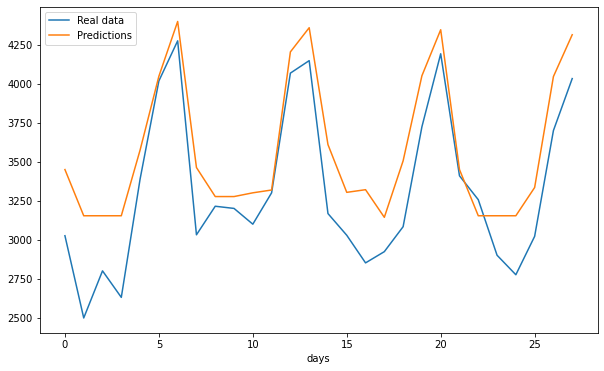

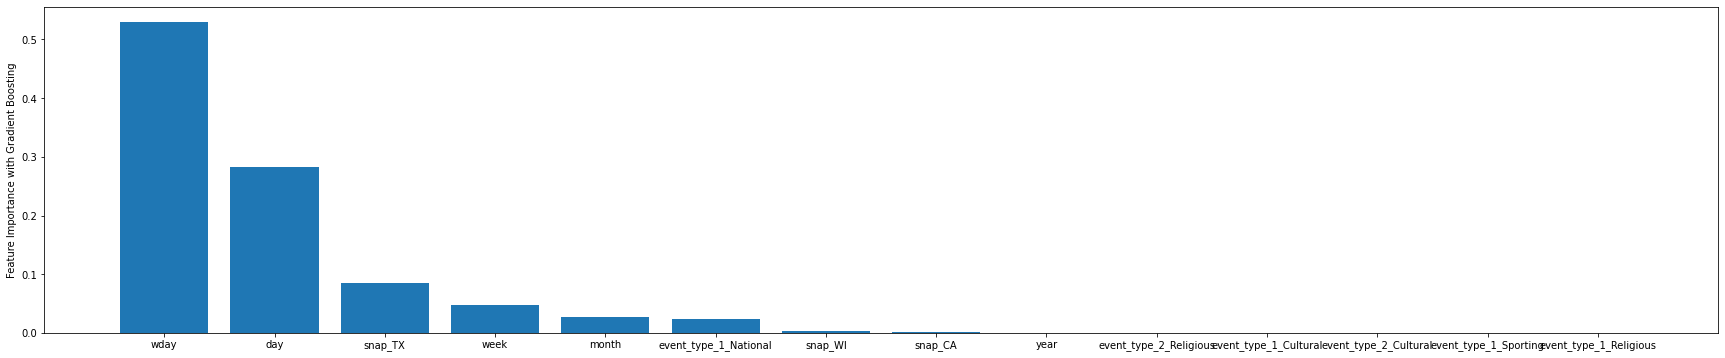

RMSSE with Random Forest: 0.2111790820973529


Random Forest Forecasting


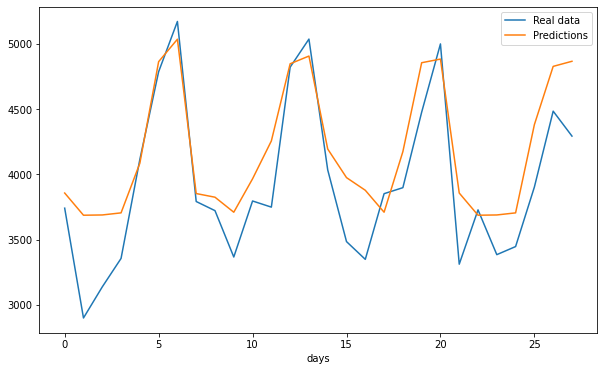

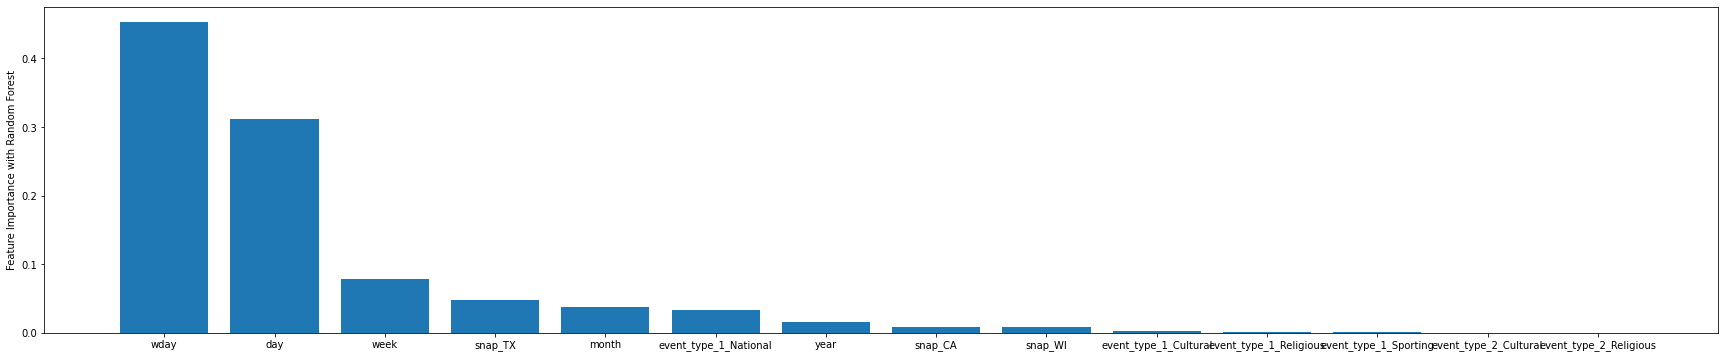

RMSSE with Gradient Boosting: 0.2533120916353614


Gradient Boosting Forecasting


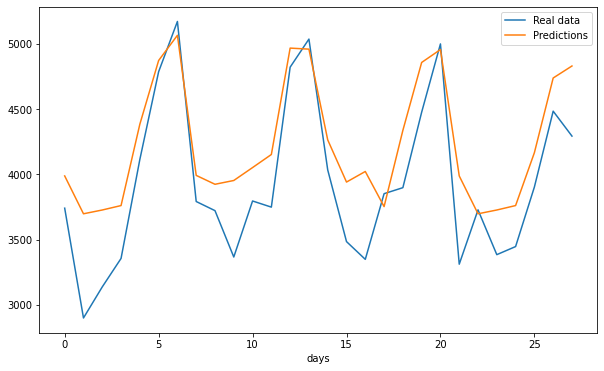

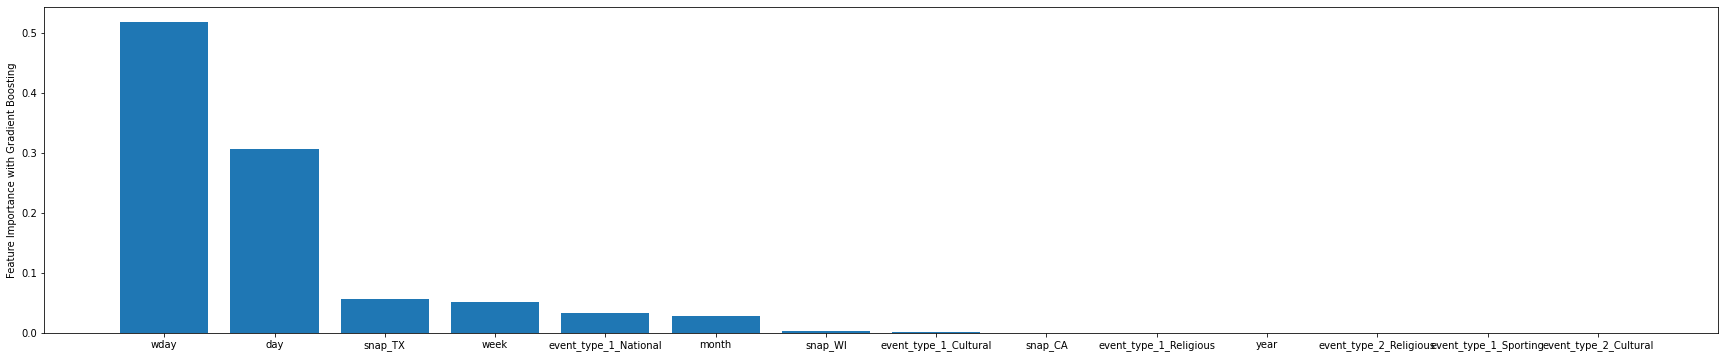

RMSSE with Random Forest: 0.2618104068897169


Random Forest Forecasting


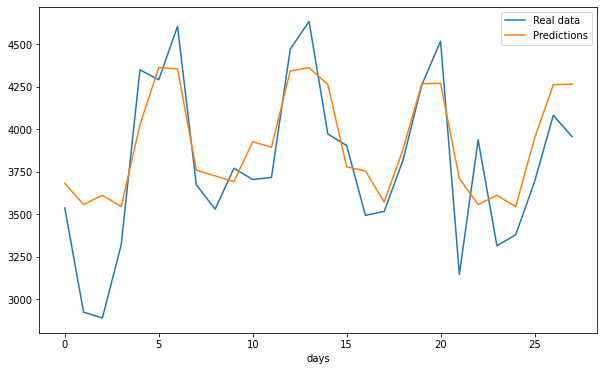

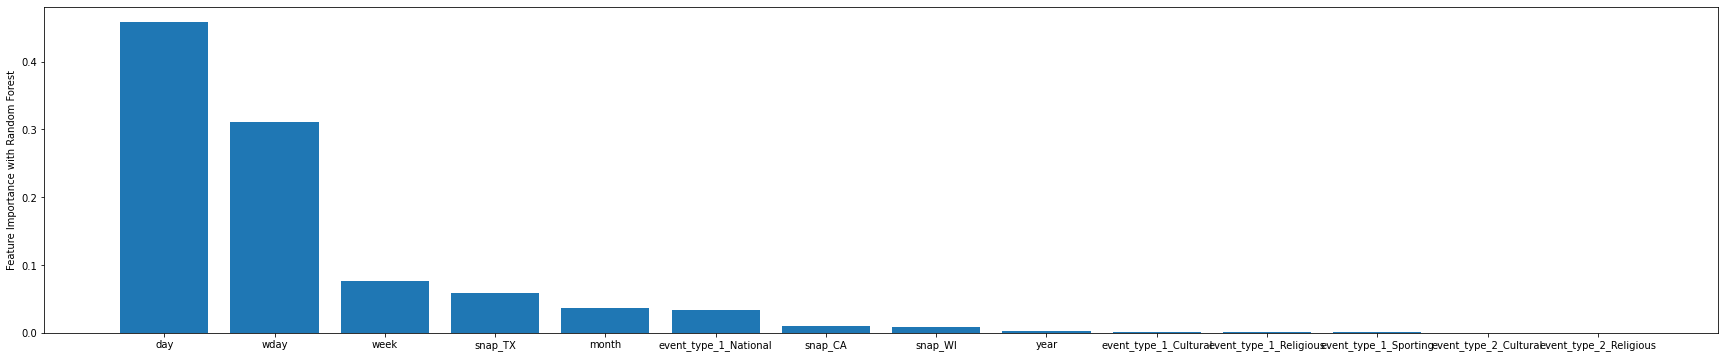

RMSSE with Gradient Boosting: 0.2756009935691696


Gradient Boosting Forecasting


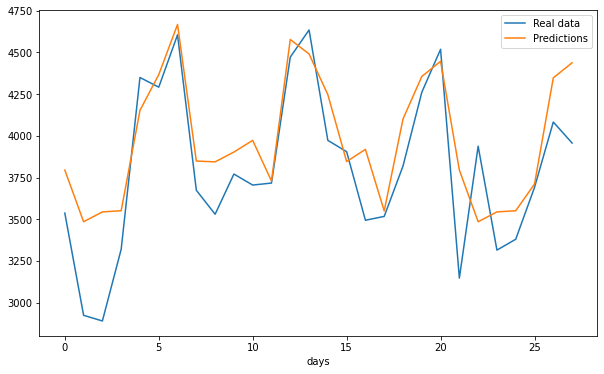

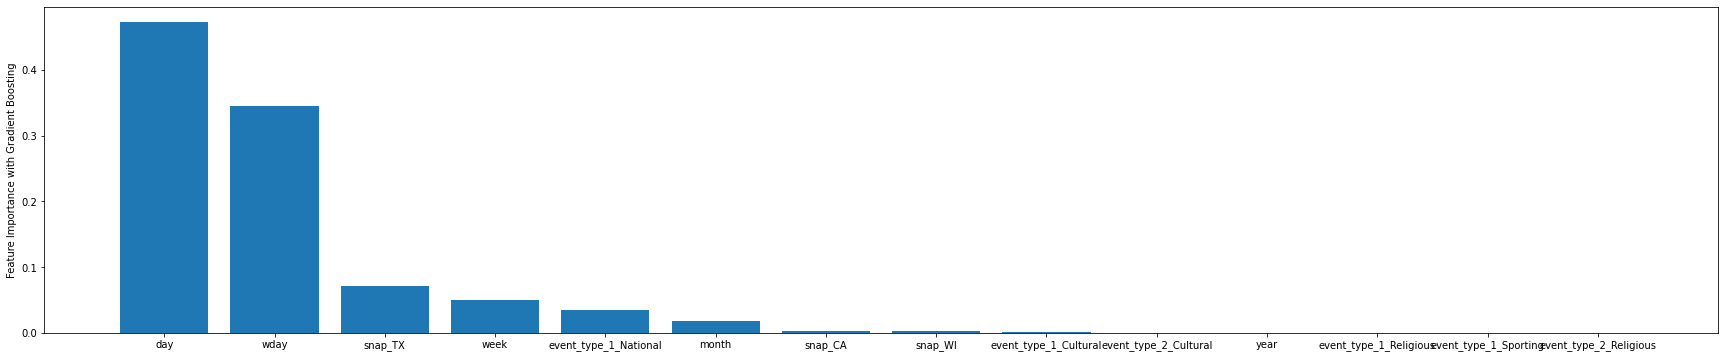

In [11]:
rf_pred_WI = []
gb_pred_WI = []
for df in [df_TX_1,df_TX_2,df_TX_3]:
    df_xtrain,df_ytrain,df_xvalid,df_yvalid = clean(df)
    rf_pred_WI.append(rf_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))
    gb_pred_WI.append(gb_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))

# 3.3 Work on California Stores

In [12]:
df_CA_1 = pd.read_csv('data_CA_1.csv')
df_CA_2 = pd.read_csv('data_CA_2.csv')
df_CA_3 = pd.read_csv('data_CA_3.csv')
df_CA_4 = pd.read_csv('data_CA_4.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RMSSE with Random Forest: 0.10731008141656065


Random Forest Forecasting


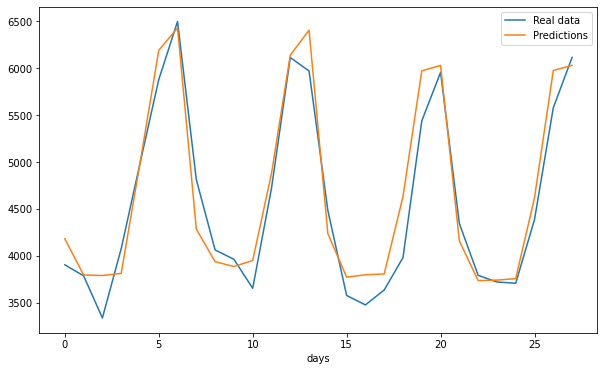

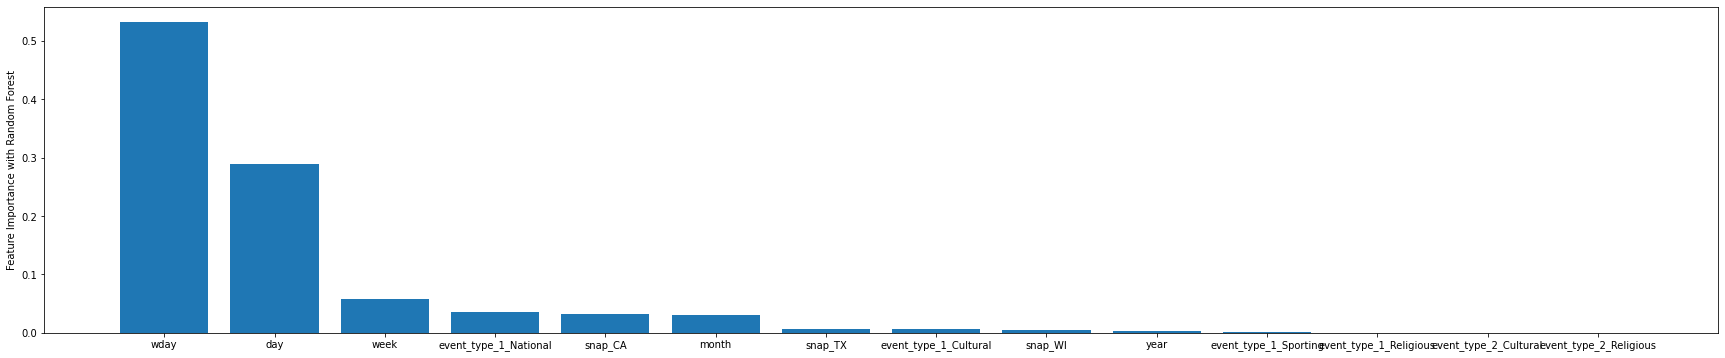

RMSSE with Gradient Boosting: 0.12090240195431538


Gradient Boosting Forecasting


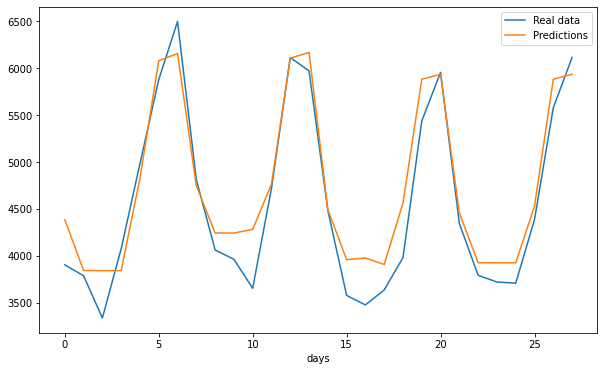

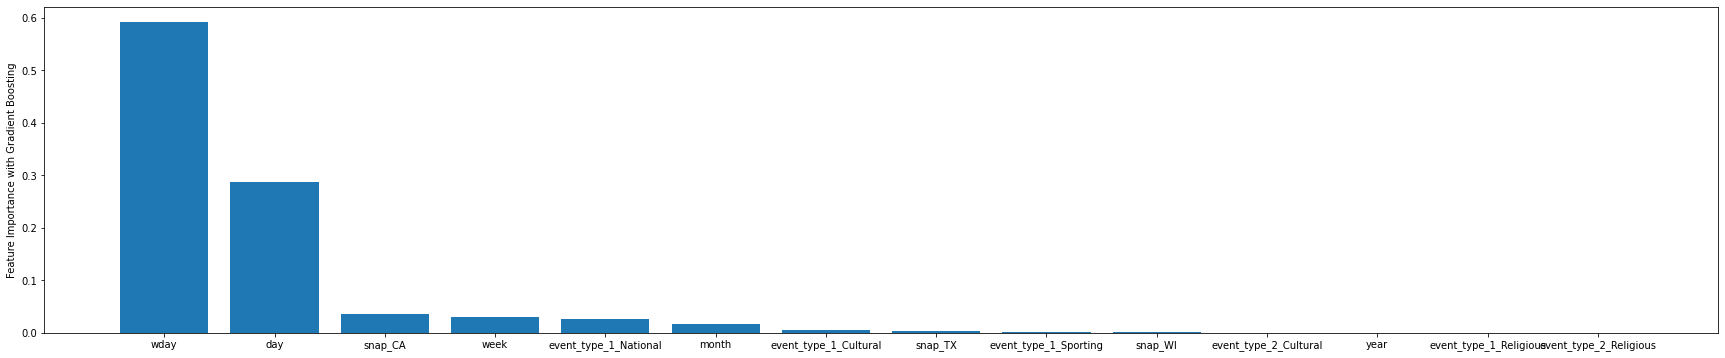

RMSSE with Random Forest: 0.30060672921036014


Random Forest Forecasting


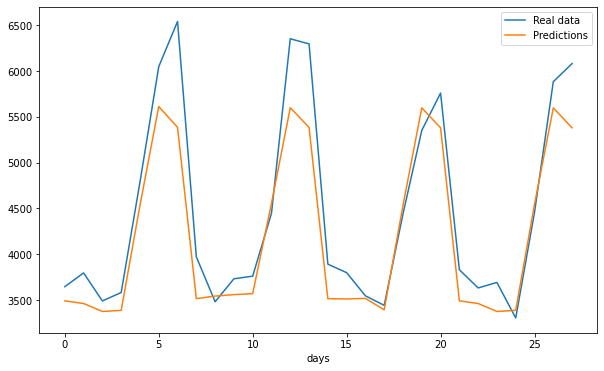

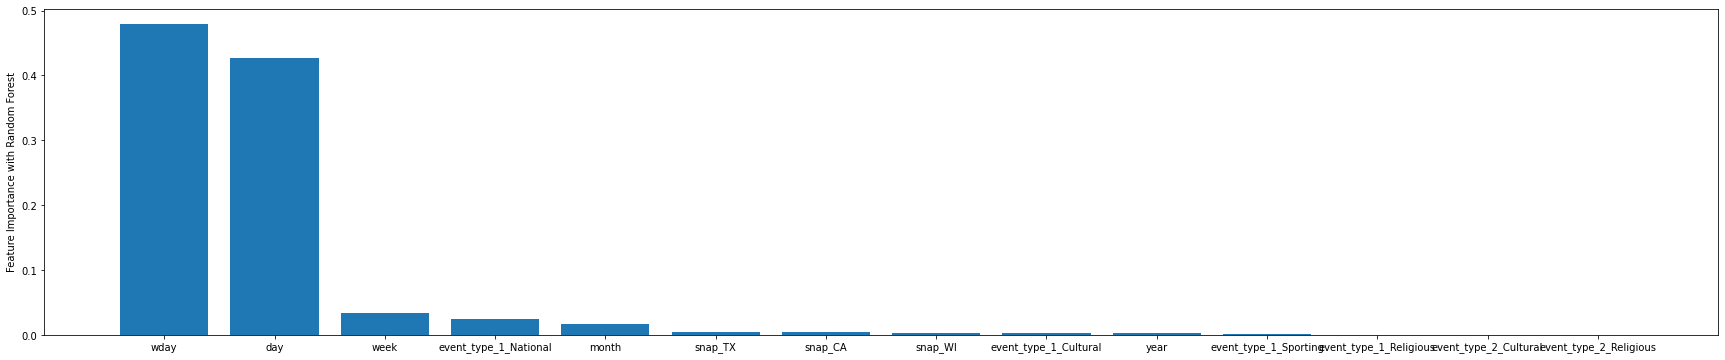

RMSSE with Gradient Boosting: 0.296393582577459


Gradient Boosting Forecasting


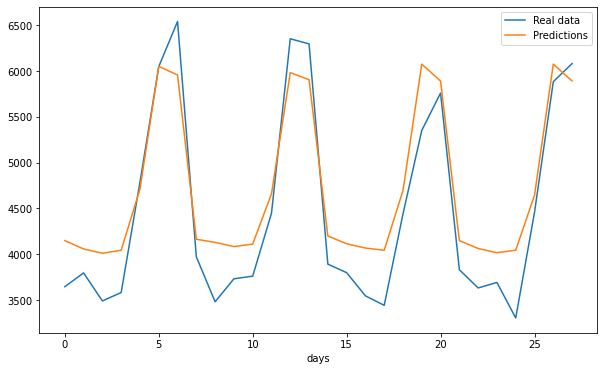

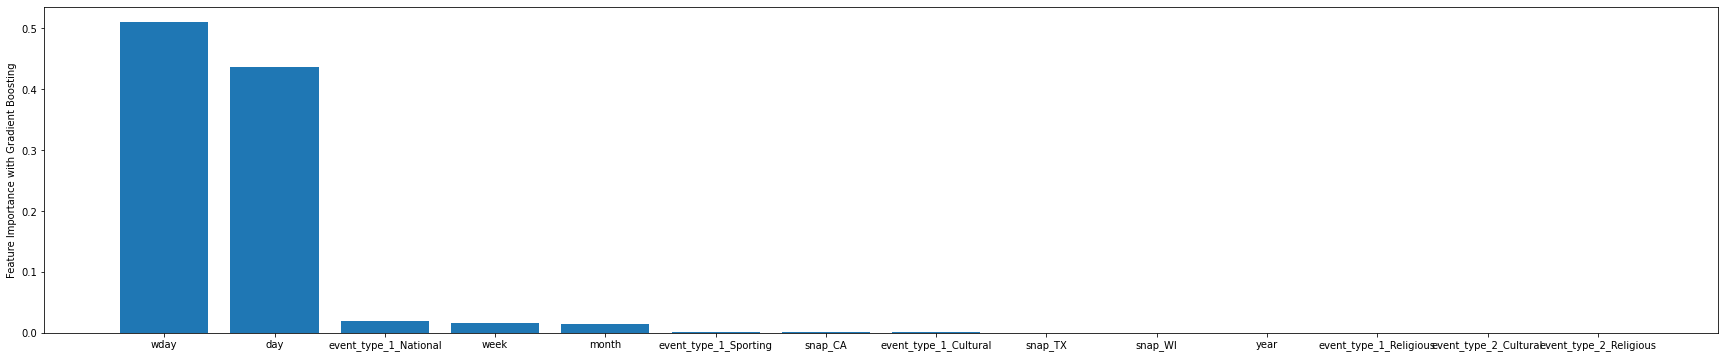

RMSSE with Random Forest: 0.1742573324522638


Random Forest Forecasting


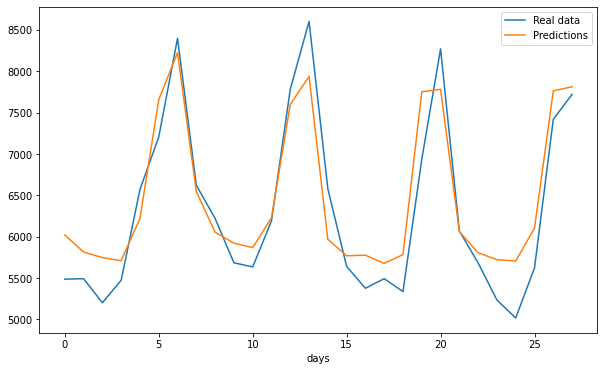

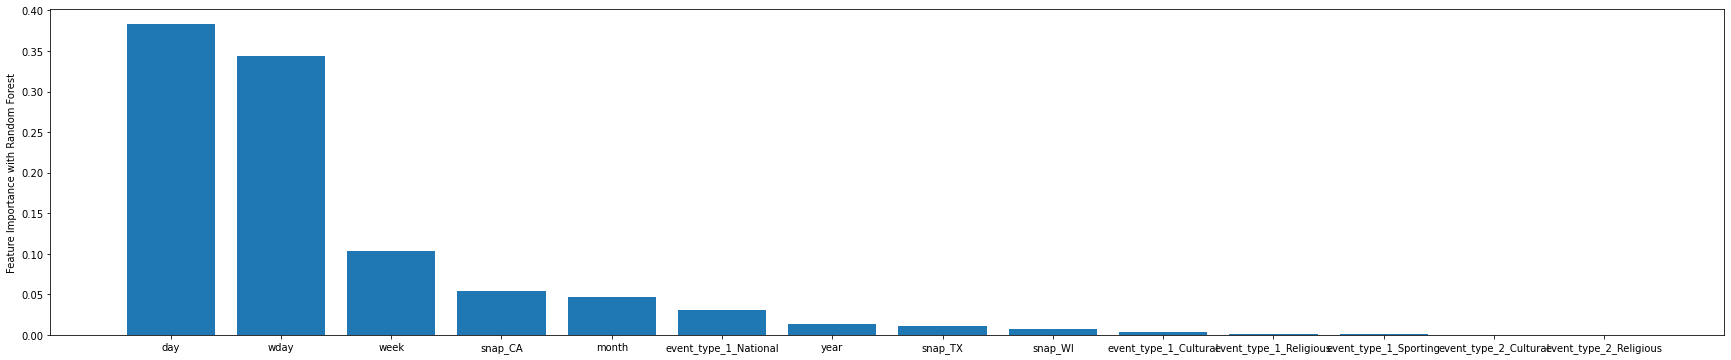

RMSSE with Gradient Boosting: 0.18931004484515232


Gradient Boosting Forecasting


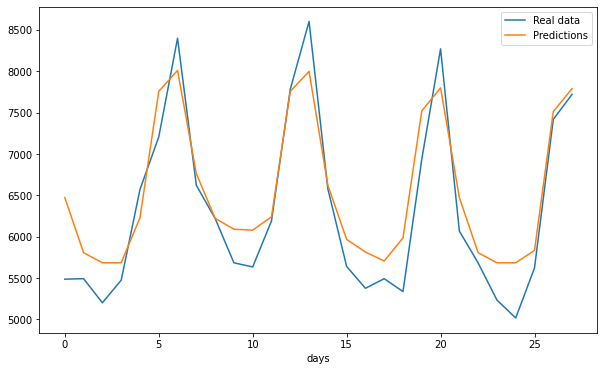

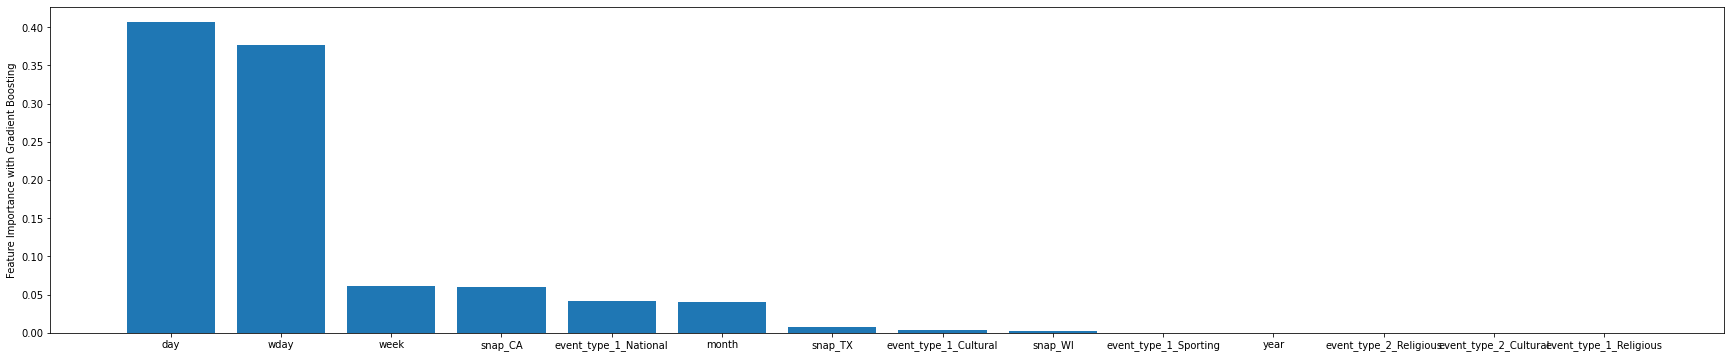

RMSSE with Random Forest: 0.23025633582313465


Random Forest Forecasting


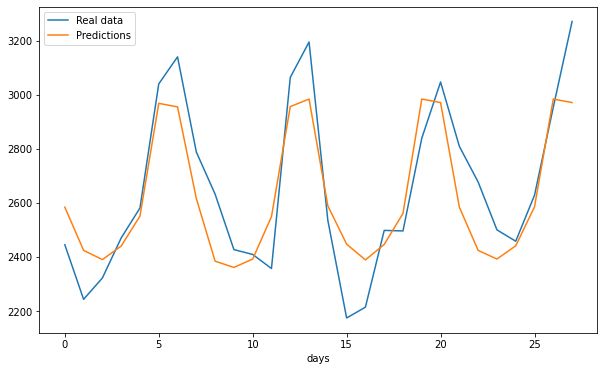

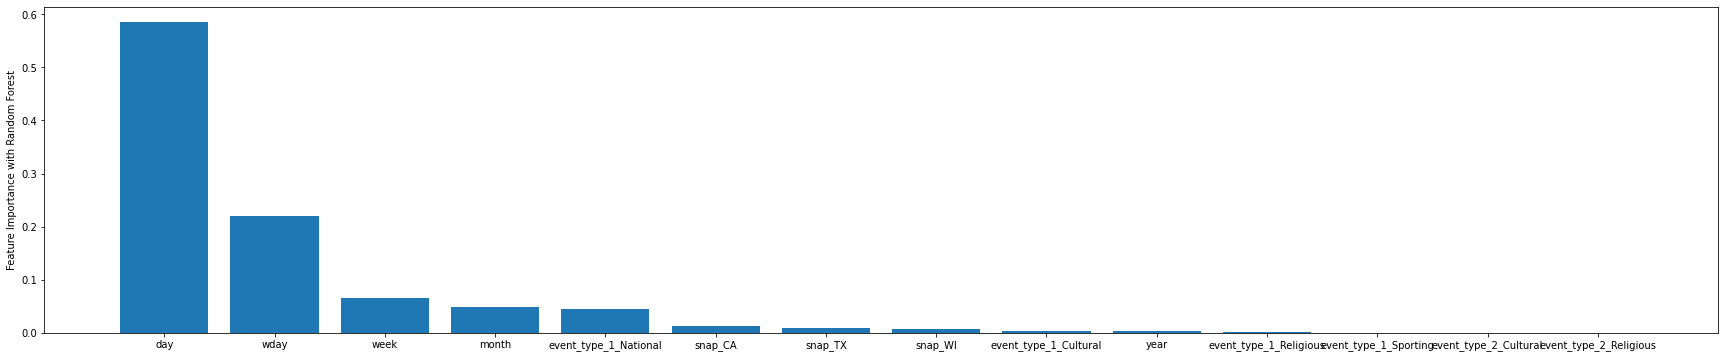

RMSSE with Gradient Boosting: 0.18935752924309301


Gradient Boosting Forecasting


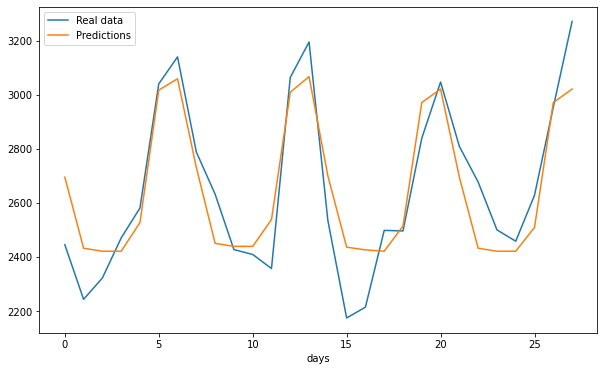

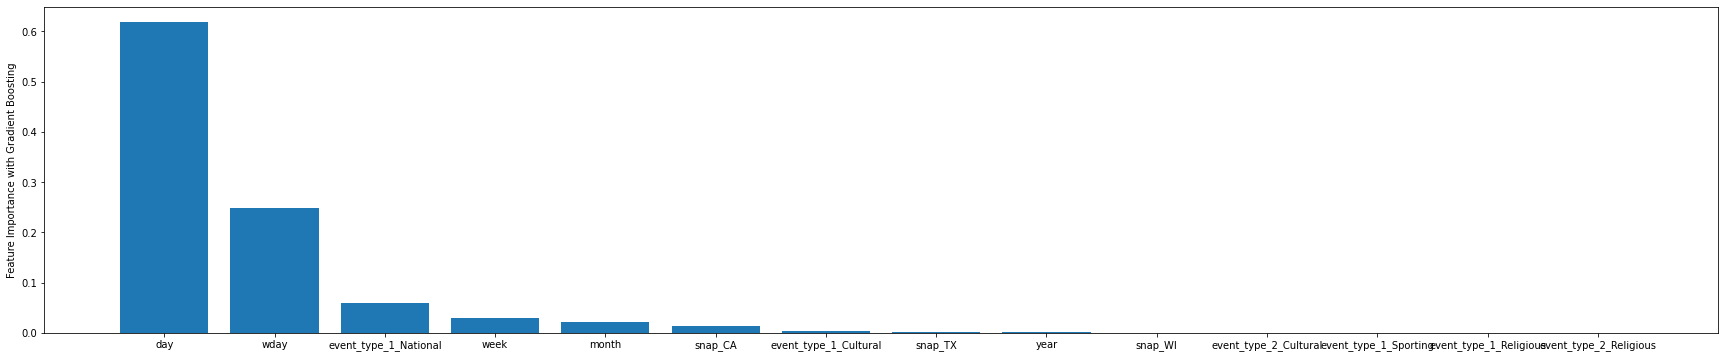

In [13]:
rf_pred_WI = []
gb_pred_WI = []
for df in [df_CA_1,df_CA_2,df_CA_3, df_CA_4]:
    df_xtrain,df_ytrain,df_xvalid,df_yvalid = clean(df)
    rf_pred_WI.append(rf_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))
    gb_pred_WI.append(gb_forecast(df_xtrain,df_ytrain,df_xvalid,df_yvalid))